# Read Data Sample

In [14]:
import pandas as pd
import numpy as np
pd.set_option("display.max_rows",15)
%matplotlib inline

In [15]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [16]:
dataset.kdd_train_2labels.shape

(125973, 123)

In [17]:
dataset.kdd_test_2labels.shape

(22544, 123)

In [18]:
class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']

    from sklearn import model_selection as ms
    from sklearn import preprocessing as pp

    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]


    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values

    x_valid, x_test, y_valid, y_test = ms.train_test_split(x_test, 
                                  y_test, 
                                  test_size=0.4)


In [19]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 121
    classes = 2
    hidden_encoder_dim = 40
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 40
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu)
            
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu)

        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = tf.nn.relu)
            
        with tf.variable_scope("Layer_Dense_Hidden"):
            hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

        with tf.variable_scope("Layer_Dense_Softmax"):
            y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = y))

            loss = tf.reduce_mean(BCE + KLD + softmax_loss)

            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=0.01
            train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.regularized_loss)
            
        # add op for merging summary
        self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(y, 1)
        self.actual = tf.argmax(self.y_, 1)

        # add Saver ops
        # saver = tf.train.Saver()
        

In [8]:
class Train:    
    def train(epochs, net):
        batch_iterations = 100

        batch_indices = np.array_split(np.arange(preprocess.x_train.shape[0]), 
                                   batch_iterations)
        with tf.Session() as sess:
            summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())

            for epoch in range(0, epochs):
                for i in batch_indices:
                    _, train_loss, summary_str = sess.run([net.optimizer, 
                                                           net.regularized_loss, 
                                                           net.summary_op],
                                                          feed_dict={net.x: preprocess.x_train[i,:], 
                                                                     net.y_: preprocess.y_train[i,:], 
                                                                     net.keep_prob:0.8})
                    summary_writer_train.add_summary(summary_str, epoch)


                accuracy, summary_str = sess.run([net.tf_accuracy, net.summary_op], 
                                                      feed_dict={net.x: preprocess.x_valid, 
                                                                 net.y_: preprocess.y_valid, 
                                                                 net.keep_prob:1})
                summary_writer_valid.add_summary(summary_str, epoch)

                if epoch % 10 == 0:
                    print("Step {} | Training Loss: {:.4f} | Validation Accuracy: {:.4f}".format(epoch, train_loss, accuracy))

            accuracy, pred_value, actual_value = sess.run([net.tf_accuracy, 
                                                           net.pred, 
                                                           net.actual], 
                                                          feed_dict={net.x: preprocess.x_test, 
                                                                     net.y_: preprocess.y_test, 
                                                                     net.keep_prob:1})


            print("Accuracy on Test data: {}".format(accuracy))
            return accuracy, pred_value, actual_value

In [9]:
import itertools
import collections
class Hyperparameters:
    features_arr = [4, 8, 16, 32, 64, 128]
    hidden_layers_arr = [2, 4, 6]
    epochs = [40]
    result = collections.namedtuple("result", ["epochs", "hidden_layers", "feature_count",
                                  "accuracy"])
    results = []
    best_acc = 0
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        acc, pred, actual = Train.train(e, n)
        if acc > best_acc:
            best_acc = acc
            pred_value = pred
            actual_value = actual
        results.append(result(e, h, f,acc))

Current Layer Attributes - epochs:40 hidden layers:2 features count:4
Step 0 | Training Loss: 0.7344 | Validation Accuracy: 0.7362
Step 10 | Training Loss: 0.1223 | Validation Accuracy: 0.7997
Step 20 | Training Loss: 0.1391 | Validation Accuracy: 0.8415
Step 30 | Training Loss: 0.1309 | Validation Accuracy: 0.8580
Accuracy on Test data: 0.7179293632507324
Current Layer Attributes - epochs:40 hidden layers:2 features count:8
Step 0 | Training Loss: 0.2584 | Validation Accuracy: 0.6944
Step 10 | Training Loss: 0.1443 | Validation Accuracy: 0.7798
Step 20 | Training Loss: 0.1634 | Validation Accuracy: 0.8222
Step 30 | Training Loss: 0.1166 | Validation Accuracy: 0.8502
Accuracy on Test data: 0.7103886008262634
Current Layer Attributes - epochs:40 hidden layers:2 features count:16
Step 0 | Training Loss: 0.0911 | Validation Accuracy: 0.6500
Step 10 | Training Loss: 0.1064 | Validation Accuracy: 0.7824
Step 20 | Training Loss: 0.1576 | Validation Accuracy: 0.8338
Step 30 | Training Loss: 0

In [10]:
df_results = pd.DataFrame(Hyperparameters.results)

In [13]:
df_results

,epochs,hidden_layers,feature_count,accuracy
0,40,2,4,0.717929
1,40,2,8,0.710389
2,40,2,16,0.723075
3,40,2,32,0.737846
4,40,2,64,0.747605
5,40,2,128,0.761666
6,40,4,4,0.430758
...,...,...,...,...
11,40,4,128,0.432887
12,40,6,4,0.430758


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.6347  0.3653]
 [ 0.0705  0.9295]]


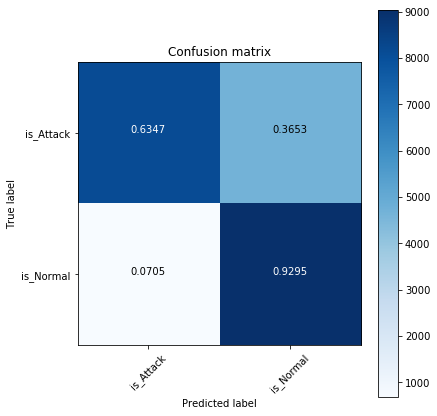

In [12]:
from sklearn.metrics import confusion_matrix
cm_2labels = confusion_matrix(y_pred = Hyperparameters.pred_value, y_true = Hyperparameters.actual_value)
plt.figure(figsize=[6,6])
plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True)